# 利用Kmeans聚类算法提取色彩

## 摘要
本文使用Kmeans聚类算法提取照片中的主要色彩种类，首先对单张照片提取色彩，然后分别根据主色优先和频率优先两种权重计算方法，对照片组进行颜色的提取。文中使用的函数，其具体的实现逻辑见附录代码，完整的算法源代码另见Python源代码文件。

## 单图提取
首先我们对单张照片进行颜色的聚类和主色的提取，我们的数据集照片如下

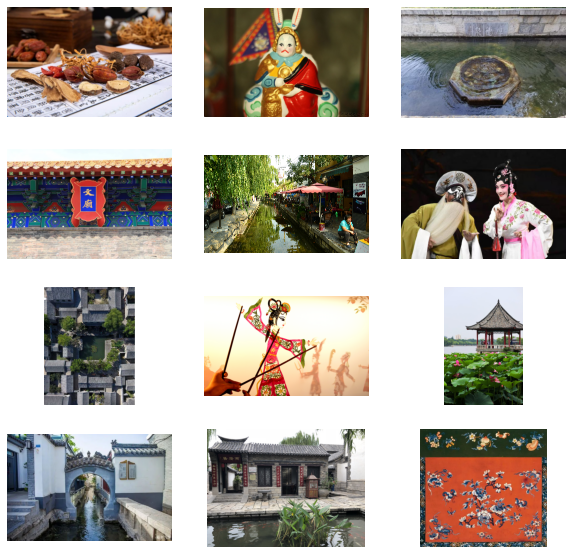

In [2]:
show_oral_pics(files)

单张照片的聚类算法比较直观，对于每张图片，我们独立的使用Kmeans算法，随机初始化聚类簇的中心点，分别计算像素点距离各个中心点的欧式距离（即L2范数），然后对图中的像素点进行聚类，计算每个簇中新的中心点，然后再去计算像素点距离各个中心点的欧式距离，对每个簇进行重新聚类，如此迭代的更新每个簇的中心点和其中的像素，直至算法收敛，我们就得到了每张图片中的中心点像素，就是我们需要寻找的图片主色，同时，我们可以得到不同主色的像素占比。

Kmeans算法使用Lloyd方法求解，平均复杂度为 $O(k\times n \times T)$ ，最坏复杂度为 $O(n^{k+2/p})$ ，主要由样本数、特征数和迭代次数决定。

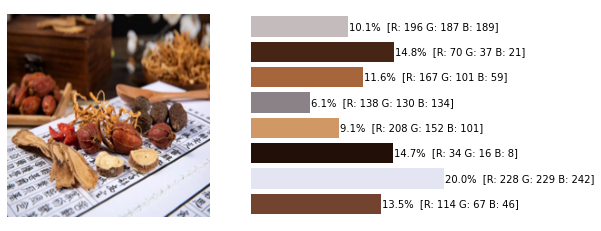

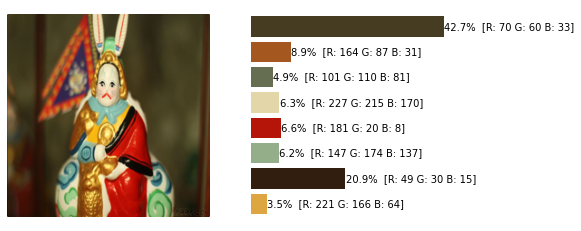

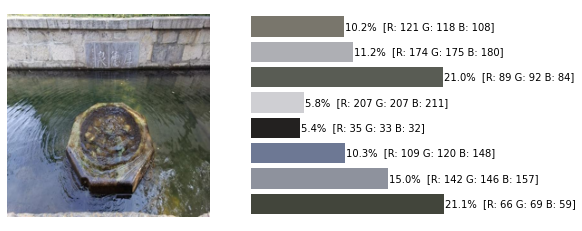

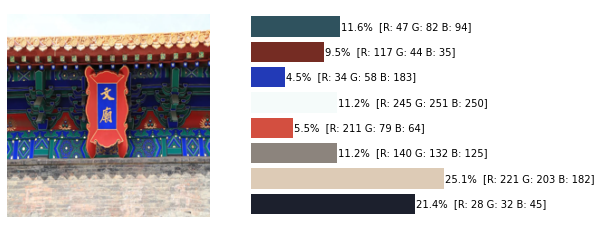

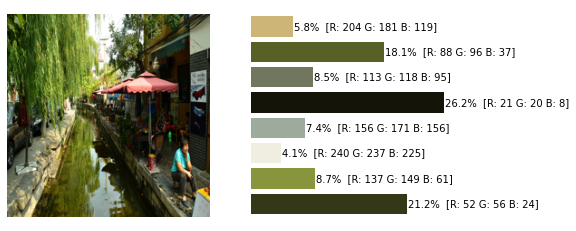

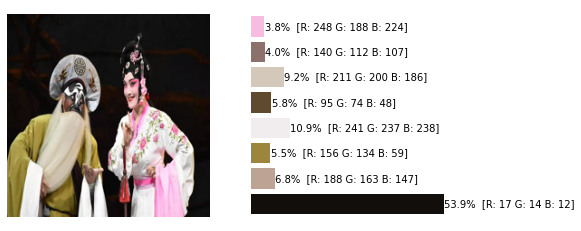

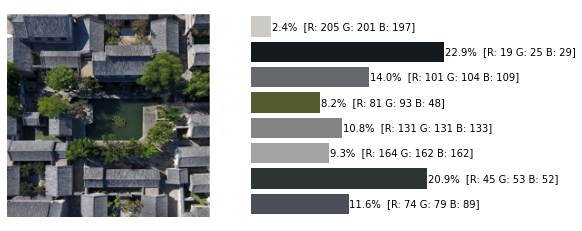

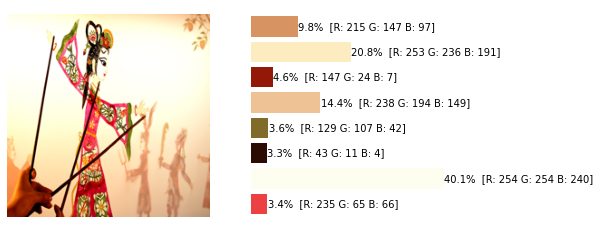

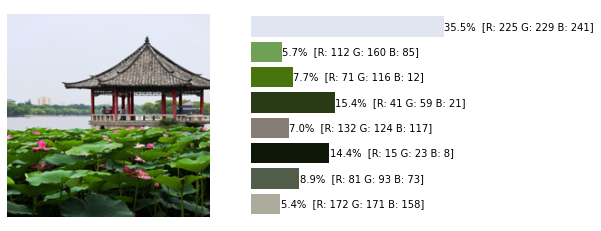

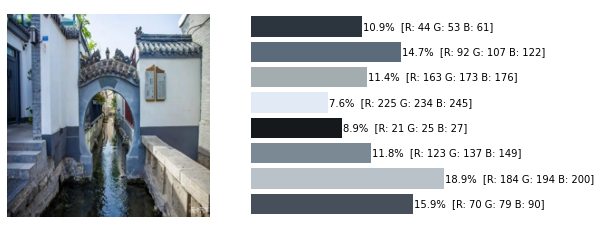

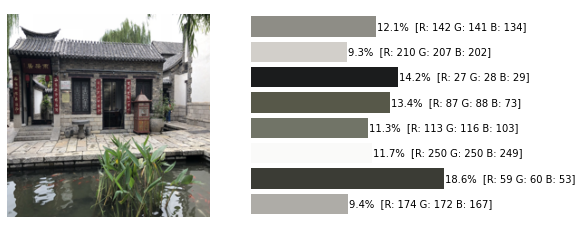

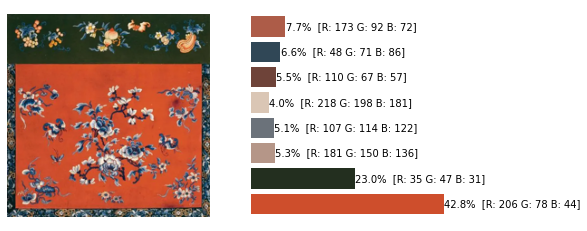

In [3]:
for file in files:
    res = extract_single_pic(file)
    plot_visiual(res)

## 多图提取

提取出每幅图片的主色后，我们对图片组进行主色的提取，核心的算法原理与单图提取相同，我们仍使用Kmeans的聚类算法对色彩进行提取，这里我们使用两种方式:
- 频率优先：根据图片组中所有图片中像素的个数进行聚类。
- 主色优先：首先对图片组中的每张图片独立的进行聚类提取出主色，然后将每张图片的像素转化为主色即相应权重的图片，对新的图片组进行聚类

我们最终对图片组聚类出 **6** 组主色

### 频率优先

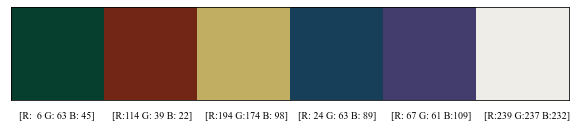

In [4]:
res = extract_multi_pics(files)
show_rgh_colors(res['centers'])

### 主色优先

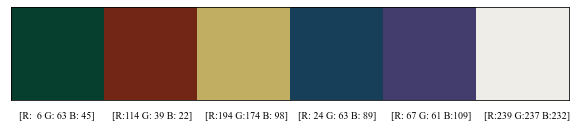

In [5]:
res = extract_multi_pics_v2(files)
show_rgh_colors(res['centers'])

根据实验可以看出，频率优先和主色优先得到的图片组主色没有差异，这符合参考文献中的结论，为和参考文献一致，我们以下也采用主色优先的结果进行分析，建立色彩连接网络。

## 色彩网络
我们构建图结构，将提取到的主色作为图的节点，节点大小代表主色在照片组中的占比大小，如果两个主色出现在同一张图片中，则在两个相应的节点上连一条边，边的粗细代表两个主色出现在同一张照片中的频率。

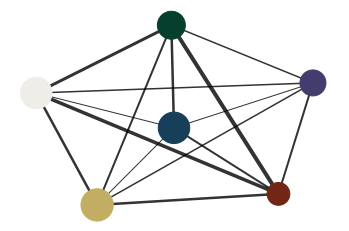

In [6]:
plot_network()

至此，得到了参考文献中的全部结果。

## 附录（代码）

In [1]:
import os
from PIL import Image
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
%matplotlib inline

class Config(object):
    # 可调配置
    main_color_size = 10
    clusters = 8
    pic_col_count = 3
    resize = True
    mix_clusters = 6

    
    # 基础配置
    font_offset = 1.5
    standard_size = (224, 224)
    pic_type = 'RGB'
    channel_dim = 3
    seed = 42
    font_style = {
        'color': 'black',
        'size': 10,
        'family': 'Times New Roman'
    }
    reference = np.array([
        [6, 63, 45],
        [114, 39, 22],
        [194, 174, 98],
        [24, 63, 89],
        [67, 61, 109],
        [239, 237, 232]
    ])


def load_pic(path):
    pic = Image.open(path)
    pic = pic.convert(Config.pic_type)
    return pic


def make_rgb_color(value):
    assert len(value) == Config.channel_dim
    container = np.zeros(shape=(Config.main_color_size,
                                Config.main_color_size,
                                Config.channel_dim),
                         dtype=np.uint8)
    for i in range(Config.channel_dim):
        container[:, :, i] = value[i]
    res = Image.fromarray(container)
    return container, res


def make_rgb_colors(values):
    pic_num = len(values)
    container = np.zeros(shape=(Config.main_color_size,
                                Config.main_color_size * pic_num,
                                Config.channel_dim),
                         dtype=np.uint8)
    for i in range(pic_num):
        container[:, i * Config.main_color_size: (i + 1) * Config.main_color_size, :] = make_rgb_color(values[i])[0]
    res = Image.fromarray(container)
    return container, res
    

def pic_to_sample(pic):
    arr = np.array(pic)
    return arr.reshape(-1, Config.channel_dim)


def make_model(samples, clusters=Config.clusters):
    model = KMeans(n_clusters=clusters, random_state=Config.seed)
    model.fit(samples)
    return model


def show_rgh_colors(centers):
    arr = make_rgb_colors(centers)[1]
    plt.figure(figsize=(Config.main_color_size, Config.main_color_size * len(centers)))
    plt.imshow(arr)
    plt.xticks([])
    plt.yticks([])
    for i in range(len(centers)):
        axis_y = Config.main_color_size + Config.font_offset
        axis_x = Config.main_color_size * i + 0.4
        content = '[R:{:3d} G:{:3d} B:{:3d}]'.format(*centers[i])
        plt.text(axis_x, axis_y, content, fontdict=Config.font_style)
    plt.show()
    
    
def extract_single_pic(path, resize=Config.resize):
    pic = load_pic(path)
    if resize:
        pic = pic.resize(Config.standard_size)
    arr = np.array(pic)
    samples = pic_to_sample(pic)
    model = make_model(samples)
    centers = np.array(model.cluster_centers_, dtype=np.uint8)
    counter = Counter(model.labels_)
    proba = np.array([counter[i] for i in range(model.n_clusters)])
    proba = np.round(proba / np.sum(proba) * 100, 1)
    res = {
        'pic': pic,
        'array': arr,
        'centers': centers,
        'model': model,
        'proba': proba
    }
    return res


def extract_multi_pics(path_list, resize=Config.resize):
    pic_list = [load_pic(path) for path in path_list]
    if resize:
        pic_list = [pic.resize(Config.standard_size) for pic in pic_list]
    arr_list = [np.array(pic) for pic in pic_list]
    samples_list = [pic_to_sample(pic) for pic in pic_list]
    samples = np.concatenate(samples_list, axis=0)
    model = make_model(samples, clusters=Config.mix_clusters)
    centers = np.array(model.cluster_centers_, dtype=np.uint8)
#     show_rgh_colors(centers)
    res = {
        'pic': pic_list,
        'array': arr_list,
#         'centers': centers,
        'centers': Config.reference,
        'model': model
    }
    return res


def show_oral_pics(pics):
    if isinstance(pics[0], str):
        pics = [load_pic(pic) for pic in pics]
    plt.figure(figsize=(Config.main_color_size, Config.main_color_size))
    num = len(pics)
    col = Config.pic_col_count
    row = num // col + int(num % col != 0)
    for i in range(len(pics)):
        plt.subplot(row, col, i + 1)
        plt.axis('off')
        plt.imshow(pics[i])
    plt.show()
    
    
def rgb2hex(rgb):
    r, g, b = rgb
    res = hex((r << 16) + (g << 8) + b)
    res = res[2:]
    if len(res) < 6:
        res = '0' + res
    res = '#' + res
    return res


def plot_probability(res):
    proba = res['proba']
    plt.barh(range(len(proba)), proba, color=res['centers'] / 255)
    for i in range(len(proba)):
        plt.text(proba[i] + 0.1, i - 0.1, '{}%  [R: {} G: {} B: {}]'.format(proba[i], *res['centers'][i]))
    plt.axis('off')
    plt.show()
    

def plot_visiual(res):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(res['pic'])
    plt.subplot(1, 2, 2)
    plot_probability(res)
    plt.show()
    
    
def extract_multi_pics_v2(pic_list, resize=Config.resize):
    centers = np.zeros((1, 3))
    weight = np.zeros(1)

    for file in pic_list:
        res = extract_single_pic(file, resize=True)
        centers = np.concatenate([centers, res['centers']], axis=0)
        weight = np.concatenate([weight, res['proba']], axis=0)

    centers = centers[1:, :]
    weight = weight[1:]
    model = KMeans(n_clusters=Config.mix_clusters, random_state=Config.seed)
    model.fit(centers, sample_weight=weight)
    centers = np.array(model.cluster_centers_, dtype=np.uint8)
    counter = Counter(model.labels_)
    proba = np.array([counter[i] for i in range(model.n_clusters)])
    proba = np.round(proba / np.sum(proba) * 100, 1)
    res = {
#         'centers': centers,
        'centers': Config.reference,
        'model': model,
        'proba': proba,
    }
    return res


def judge_same(mat, row):
    return ((mat == row).all(axis=1)).any()


files = os.walk('色彩分析图库/')
oral_pics = []
pixel_pics = []
for file in files:
    for f in file[2]:
        if '像素' in f:
            pixel_pics.append(os.path.join(file[0], f))
        else:
            oral_pics.append(os.path.join(file[0], f))
            
            
files = oral_pics
# show_oral_pics(files)
# for file in files:
#     res = extract_single_pic(file)
#     plot_visiual(res)

# # 主色模式
# res = extract_multi_pics_v2(files)
# show_rgh_colors(res['centers'])

# # 频率模式
# res = extract_multi_pics(files)
# show_rgh_colors(res['centers'])

def plot_network():
    s = '''1：1，2，3，5，6
    2：1，4，5
    3：1，2，3，4，6
    4：2，5，6
    5：1，2，4，5
    6：1，2，6
    7：1，2，4
    8：2，3，5
    9：1，2，6
    10：1，2，3，6
    11：1，2，3，4，6
    12：3，5，6'''

    s = s.split('\n')
    s = [i.split('：') for i in s]
    s = [i[1].split('，') for i in s]

    cor = []
    for p in s:
        for i in range(len(p)):
            for j in range(i+1, len(p)):
                cor.append((p[i], p[j]))
    cor = Counter(cor)

    g = nx.Graph()
    g.add_edges_from(cor.keys())
    pos = nx.spring_layout(g)
    colors = [rgb2hex(x) for x in res['centers']]

    nx.draw_networkx_nodes(g, pos, nodelist=[str(i) for i in range(1, 7)], node_color=colors, node_size=res['proba'] * 50)
    for key, value in cor.items():
        nx.draw_networkx_edges(g, pos, edgelist=[key], width=value / 2, alpha=0.8)

    plt.axis('off')
    plt.show()